In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from copy import deepcopy
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

from data import read_audio, AudioData
from data.metadata.vcc import (
    SanityMetadata, VCC2016TrainMetadata,
    VCC2016TrainAppendedMetadata)
import data.transform
from data.transform import log_stft, db_to_amp, dft_filter
from data.dataset import (
    TaskDataset, InputData,
    from_gen_model_output, to_gen_model_output)
from env import sr, frame_size
from loss import MSE, MelMSE, MelMeanFilteredMSE, MelGaussianFilteredMSE, \
    ScaledMSE
from models import save_model, load_model
from models.vae import ToyVAE, MultiFeaturePerceptron, CustomModel
from maml import reptile_train
from visualization import plot_spec
from vocoder import griffin_lim
from utils import get_model_param_count

plt.style.use({'figure.facecolor':'white'})

C:\Programs\Anaconda3\envs\pytorch-geometric\lib\site-packages\torchaudio\extension\extension.py:13: UserWarning: torchaudio C++ extension is not available.
  warnings.warn('torchaudio C++ extension is not available.')


In [3]:
def sound(x, rate=sr, label=''):
    from IPython.display import display, Audio, HTML
    display(HTML(
        '<style> table, th, td {border: 0px; }</style> <table><tr><td>'
        + label + '</td><td>' + Audio(x, rate=rate)._repr_html_()[3:]
        + '</td></tr></table>'
    ))

def sci(num):
    return '{:e}'.format(num)

In [4]:
# meta_data = SanityMetadata()
# meta_data = VCC2016TrainMetadata()
meta_data = VCC2016TrainAppendedMetadata()

In [5]:
from models.source_filter_model import AutoEncoderDataset
auto_encoder_dataset = AutoEncoderDataset(meta_data)
print('Auto encoder data loaded', datetime.now())

Auto encoder data loaded 2021-12-15 10:27:25.283256


# Train Envelope AutoEncoder

In [6]:
from models.source_filter_model import EnvelopeAE

In [13]:
device = torch.device('cuda')
env_ae = EnvelopeAE().to(device)

# criterion = MSE()
env_ae_criterion = nn.MSELoss()

if isinstance(env_ae_criterion, nn.Module):
    formant_coder_criterion = env_ae_criterion.to(device)

env_ae_optimizer = optim.Adam(
    env_ae.parameters(), lr=2e-3, weight_decay=0)

In [14]:
np.random.seed(0)
torch.manual_seed(0)
def train_formant_coder(
        model, n_iter=2000, log_period=20, test_proportion=0.3):
    model.train()
    for i in range(n_iter):
        idx = np.random.randint(auto_encoder_dataset.n_audios)
        tae, ceps_env = auto_encoder_dataset[idx]
        x_s = [tae, ceps_env]
        for x in x_s:
            x = torch.from_numpy(x.astype(np.float32))
            x = x.transpose(0, 1)
            x = x.to(device)
            if test_proportion is None or test_proportion == 0:
                train_x = x
            else:
                test_indices = np.random.choice(x.shape[0],
                                                int(x.shape[0] * test_proportion))
                mask = np.zeros(x.shape[0], dtype=bool)
                mask[test_indices] = True
                test_x = x[mask]
                train_x = x[~mask]
            env_ae_optimizer.zero_grad()
            out = model(train_x)
            loss = formant_coder_criterion(out[:, :], train_x[:, :])
            loss.backward()
            env_ae_optimizer.step()
            if log_period is not None and i % log_period == 0:
                print('Pass', i, ': ', sci(loss.item()), end='')
                if test_proportion is not None and test_proportion != 0:
                    with torch.no_grad():
                        out = model(test_x)
                        loss = formant_coder_criterion(out[:, :], test_x[:, :])
                        print('; Test', i, ': ', sci(loss.item()), end='')
                print()
train_formant_coder(env_ae)
save_model('saved_models/' +
           type(env_ae).__name__ + '.pt', env_ae)

Pass 0 :  3.584481e+03; Test 0 :  3.179663e+03
Pass 0 :  2.745820e+03; Test 0 :  2.755793e+03
Pass 20 :  1.295789e+03; Test 20 :  1.155090e+03
Pass 20 :  8.887916e+02; Test 20 :  8.444283e+02
Pass 40 :  3.122871e+02; Test 40 :  3.046719e+02
Pass 40 :  2.411444e+02; Test 40 :  2.356996e+02
Pass 60 :  2.768370e+02; Test 60 :  2.808556e+02
Pass 60 :  2.516653e+02; Test 60 :  2.429996e+02
Pass 80 :  2.389519e+02; Test 80 :  2.318414e+02
Pass 80 :  1.913478e+02; Test 80 :  1.921782e+02
Pass 100 :  2.032022e+02; Test 100 :  2.002909e+02
Pass 100 :  1.532354e+02; Test 100 :  1.593118e+02
Pass 120 :  2.037725e+02; Test 120 :  2.086608e+02
Pass 120 :  1.824417e+02; Test 120 :  1.731487e+02
Pass 140 :  1.555937e+02; Test 140 :  1.593924e+02
Pass 140 :  1.332767e+02; Test 140 :  1.352387e+02
Pass 160 :  1.499527e+02; Test 160 :  1.509655e+02
Pass 160 :  1.229101e+02; Test 160 :  1.169530e+02
Pass 180 :  1.494847e+02; Test 180 :  1.539923e+02
Pass 180 :  1.239547e+02; Test 180 :  1.201077e+02
Pass

In [ ]:
# # test formant coder
# env_ae = load_model(
#     'saved_models/' + EnvelopeAE.__name__ + '.pt',
#     EnvelopeAE).to(device)
#
# with torch.no_grad():
#     idx = 10
#     x, _ = auto_encoder_dataset[idx]
#     amp = auto_encoder_dataset.all_audios[idx].amp
#     sound(griffin_lim(amp), label='Original')
#     amp = auto_encoder_dataset.all_audios[idx].normalized_amp()
#     lo, hi = dft_filter(log_stft(amp))
#     hi = log_stft(amp) - lo
#     plot_spec(x)
#     x = torch.from_numpy(x.astype(np.float32))
#     predicted = env_ae(x.transpose(0, 1).to(device)).detach().cpu().numpy().T
#     plot_spec(predicted)
#     recon = lo.copy()
#     recon[:, auto_encoder_dataset.all_audios[idx].selected_frames] = predicted
#     sound(griffin_lim(db_to_amp(recon+hi)* np.sqrt(
#         auto_encoder_dataset.all_audios[idx].frame_energy).reshape((1, -1))),
#         label='Reconstructed')

In [16]:
del auto_encoder_dataset

# Train Envelope transformer

In [25]:
from models.source_filter_model import (
    EnvelopeTransformer, SourceFilterTaskDataset
)

env_ae = load_model(
    'saved_models/' + EnvelopeAE.__name__ + '.pt',
    EnvelopeAE).to(device)

In [26]:
# dataset = SplitModelMetaDataset(meta_data)
# dataset.read_and_preprocess()
# print('Split meta data loaded', datetime.now())

In [27]:
class OptimizerMgr:
    def __init__(self):
        self.instance = None
    def create_instance(self, model):
        # self.instance = optim.SGD(model.parameters(),
        #                           lr=1e-3, weight_decay=0) # 2e-4
        # self.instance = optim.Adam(model.parameters(),
        #                            lr=1e-5, weight_decay=0)
        self.instance = optim.Adam(model.parameters(),
                                   lr=1e-3, weight_decay=0)

    def get(self):
        return self.instance

env_transformer_optimizer_mgr = OptimizerMgr()

In [39]:
env_transformer_criterion = nn.MSELoss()

# criterion = nn.L1Loss()
# criterion = MelMSE(is_input_log_amp=True, n_mel=512)
# criterion = MelMeanFilteredMSE(max_filter_size=10)
# criterion = MelGaussianFilteredMSE(max_filter_size=8)
if isinstance(env_transformer_criterion, nn.Module):
    env_transformer_criterion = env_transformer_criterion.to(device)

def train_formant_transformer(model, x, y,
          n_iter=1000, log_period=None, test_proportion=0.2):
    # optimizer_mgr.create_instance(model)
    optimizer = env_transformer_optimizer_mgr.get()
    model.train()
    x_s, y_s = x, y
    # x = x.transpose(0, 1)
    # y = y.transpose(0, 1)
    for i in range(n_iter):
        for idx in range(len(x_s)):
            x = x_s[idx]
            y = y_s[idx]
            x = x.to(device)
            y = y.to(device)
            if test_proportion is None or test_proportion == 0:
                train_x, train_y = x, y
            else:
                test_indices = np.random.choice(x.shape[0],
                                                int(x.shape[0] * test_proportion))
                mask = np.zeros(x.shape[0], dtype=bool)
                mask[test_indices] = True
                test_x, test_y = x[mask], y[mask]
                train_x, train_y = x[~mask], y[~mask]
                with torch.no_grad():
                    test_y_decoded = env_ae.decode(test_y)
            with torch.no_grad():
                train_y_decoded = env_ae.decode(train_y)
            for _ in range(2):
                optimizer.zero_grad()
                out = model(train_x)
                # loss = criterion(out[:, :], train_y[:, :])
                loss = env_transformer_criterion(
                    env_ae.decode(out), train_y_decoded)

                loss.backward()
                optimizer.step()
                if log_period is not None and i % log_period == 0:
                    print('Pass', i, ': ', sci(loss.item()), end='')
                    if test_proportion is not None and test_proportion != 0:
                        with torch.no_grad():
                            out = model(test_x)
                            # loss = criterion(out[:, :], test_y[:, :])
                            loss = env_transformer_criterion(
                                env_ae.decode(out), test_y_decoded)
                            print('; Test', i, ': ', sci(loss.item()), end='')
                    print()

In [38]:
env_transformer = EnvelopeTransformer().to(device)


161.61543675367054 208.92036393803963
108.67088607594937 208.92036393803963


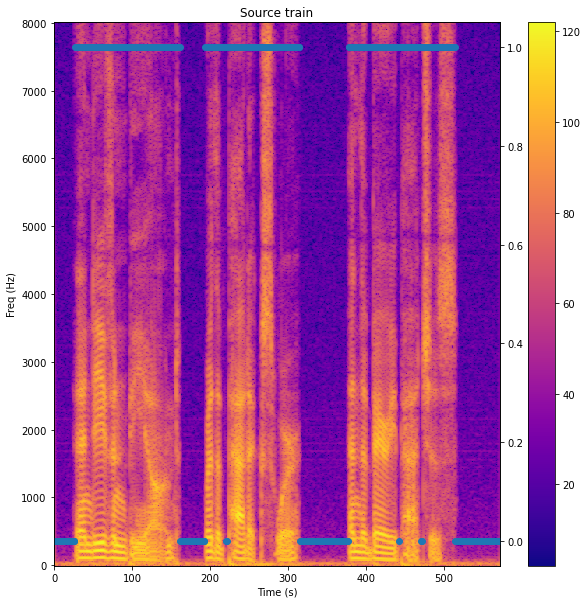

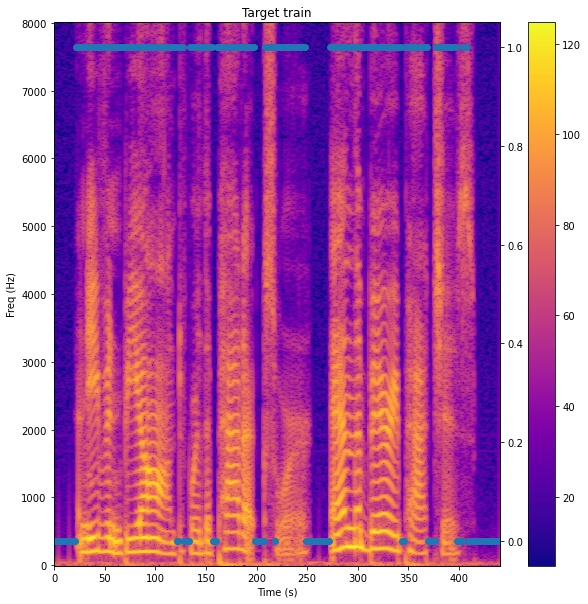

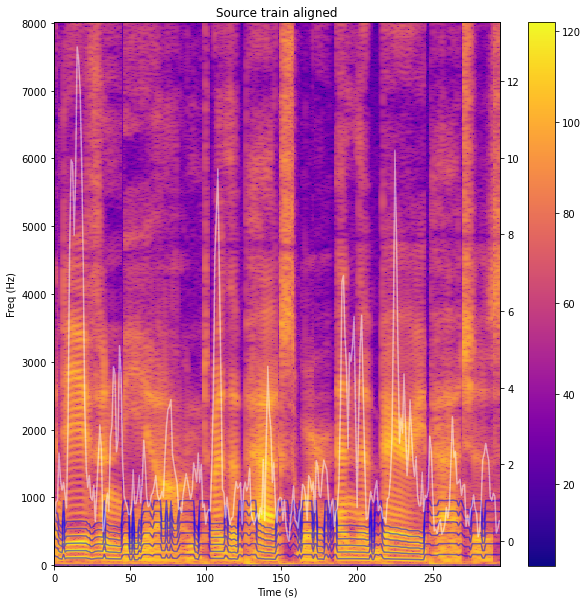

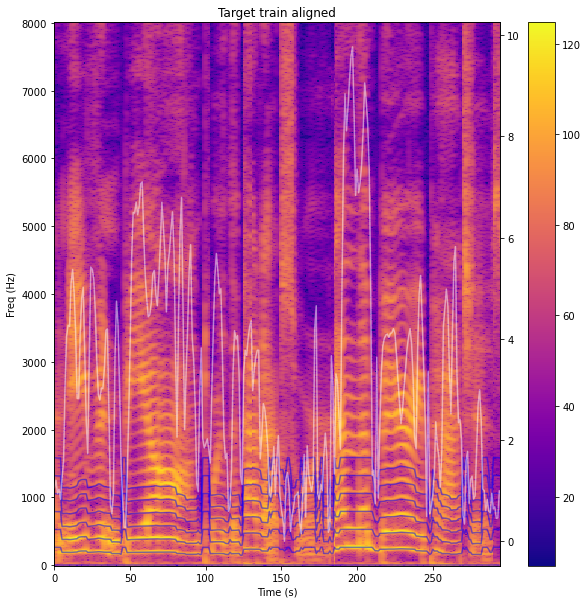

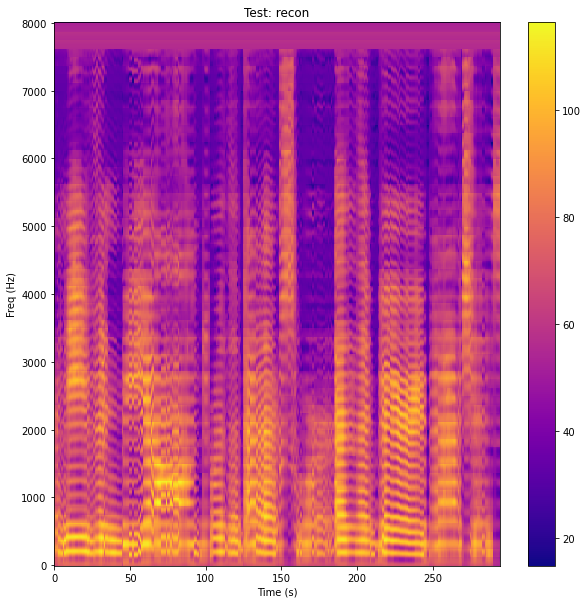

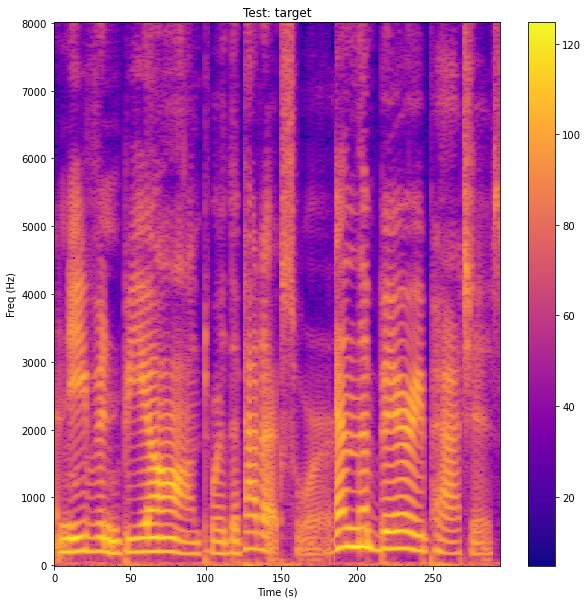

In [56]:
"""
This code block tests whether a model is "learnable" for a certain task
It simply fixes a single task and trains the model, and then it checks
model performance w.r.t. train set.
"""
from data.fundamental_freq import FundamentalFreqEstimator
from models.source_filter_model import Reconstructor
import env
env_transformer_optimizer_mgr.create_instance(env_transformer)

def formant_transformer_learnable_test(
        model, train_source_filename, train_target_filename, vocode=True, train=False):
    def plot_selected_frames(selected_frames):
        plt.twinx()
        plt.scatter(np.arange(selected_frames.size), selected_frames)
    def plot_f0(log_amp, estimator:FundamentalFreqEstimator):
        f0, prob = estimator.estimate(log_amp)
        for i in range(7):
            plt.plot(i*f0, alpha=0.5,c='b')
        plt.twinx()
        plt.plot(prob, alpha=0.5, c='w')

    # raw audio
    task_dat = SourceFilterTaskDataset(train_source_filename,
                                       train_target_filename)
    plot_spec(log_stft(task_dat.source.amp), freq=env.freq,
              title='Source train', figure_size=(10,10))
    plot_selected_frames(task_dat.source.selected_frames)
    sound(read_audio(train_source_filename), label='Source train')
    plot_spec(log_stft(task_dat.target.amp), freq=env.freq, title='Target train',
              figure_size=(10,10))
    plot_selected_frames(task_dat.target.selected_frames)
    sound(read_audio(train_target_filename), label='Target train')
    # aligned audio
    amp_x_aligned, amp_y_aligned = task_dat.get_as_aligned_amp()
    log_amp_x_aligned = log_stft(amp_x_aligned)
    log_amp_y_aligned = log_stft(amp_y_aligned)
    f0_est_source = FundamentalFreqEstimator(log_amp_x_aligned)
    f0_est_target = FundamentalFreqEstimator(log_amp_y_aligned)
    plot_spec(log_stft(amp_x_aligned), title='Source train aligned',
              freq=env.freq,
              figure_size=(10,10))
    plot_f0(log_amp_x_aligned, f0_est_source)
    plot_spec(log_stft(amp_y_aligned), title='Target train aligned',
              freq=env.freq,
          figure_size=(10,10))
    plot_f0(log_amp_y_aligned, f0_est_target)
    # train
    if vocode and False:
        aligned_1 = griffin_lim(amp_x_aligned)
        aligned_2 = griffin_lim(amp_y_aligned)
        sound(aligned_1, label='Source train aligned')
        sound(aligned_2, label='Target train aligned')
        sound((aligned_1+aligned_2)/2, label='Combined aligned')

    # Generate task
    x, y = task_dat.get()
    x = [torch.from_numpy(item.astype(np.float32).T).to(device) for item in x]
    y = [torch.from_numpy(item.astype(np.float32).T).to(device) for item in y]
    # transform to embedding
    with torch.no_grad():
        x = [env_ae.encode(item) for item in x]
        y = [env_ae.encode(item) for item in y]
    env_transformer_optimizer_mgr.create_instance(model)
    if train:
        train_formant_transformer(
            model, x, y,
            n_iter=1000, log_period=20)
    # reconstruction

    print(f0_est_source.average_f0, f0_est_target.average_f0)
    print(f0_est_source.best_f0, f0_est_target.best_f0)

    reconstructor = Reconstructor()


    def test_sample(test_task_dataset):
        from env import frame_size
        # Generate task
        x, y = test_task_dataset.get()
        amp_x, amp_y = test_task_dataset.get_as_aligned_amp()
        log_amp_x, log_amp_y = log_stft(amp_x), log_stft(amp_y)
        f0_estimated, _ = FundamentalFreqEstimator.transform(
            log_amp_x, f0_est_source, f0_est_target)
        x = [torch.from_numpy(item.astype(np.float32).T).to(device) for item in x]
        # transform to embedding
        with torch.no_grad():
            x = [env_ae.decode(env_transformer(env_ae.encode(item))) for item in x]
            x = [item.transpose(0,1).detach().cpu().numpy() for item in x]
            tae, ceps_env = x[0], x[1]
        log_amp_y_est = reconstructor.get_log_amp(tae, ceps_env, f0_estimated)
        plot_spec(log_amp_y_est, freq=env.freq, title='Test: recon', figure_size=(10,10))
        plot_spec(log_amp_y, freq=env.freq, title='Test: target',figure_size=(10,10))
        if vocode:
            amp_y_recon = db_to_amp(log_amp_y_est)
            amp_y_recon[-30:] = 0

            def conserve_energy(recon_amp, source_amp):
                eng_recon = np.sqrt(np.average(recon_amp ** 2, axis=0)).reshape((1, -1))
                eng_src = np.sqrt(np.average(source_amp ** 2, axis=0)).reshape((1, -1))
                return recon_amp * eng_src / eng_recon

            amp_y_recon = conserve_energy(amp_y_recon, amp_x)

            sound(griffin_lim(amp_y_recon),
                  label='Test: estimate')
            sound(griffin_lim(db_to_amp(log_amp_y)), label='Test: target')

    test_sample(task_dat)

formant_transformer_learnable_test(env_transformer,
                                   meta_data.get(3, 0), meta_data.get(0, 0))


128.4038248054669 218.68264105294256
102.65822784810126 218.68264105294256


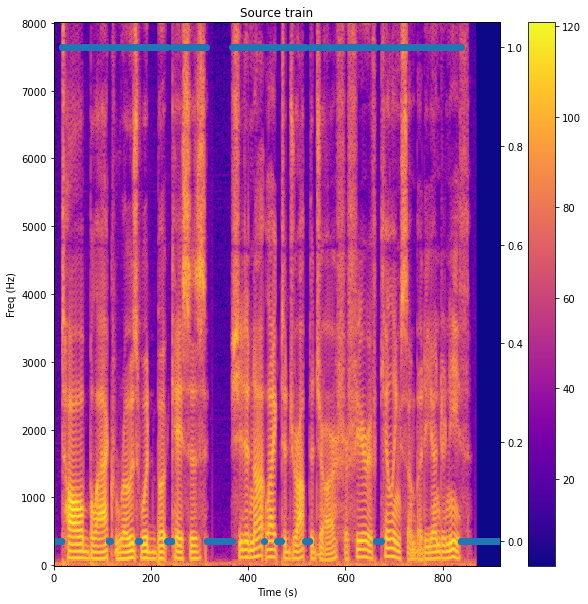

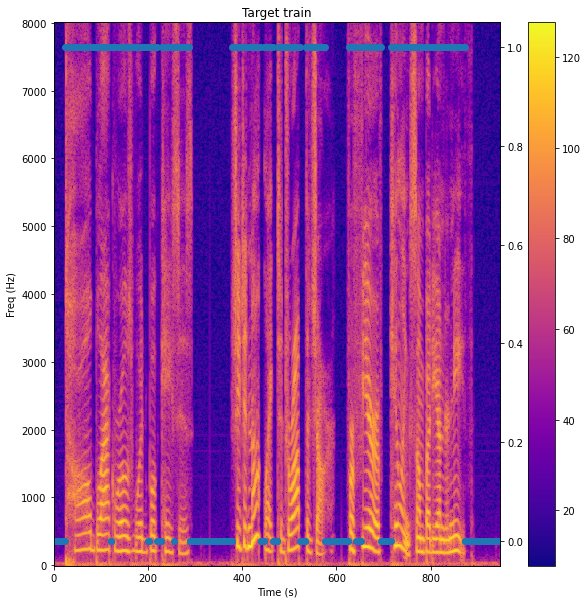

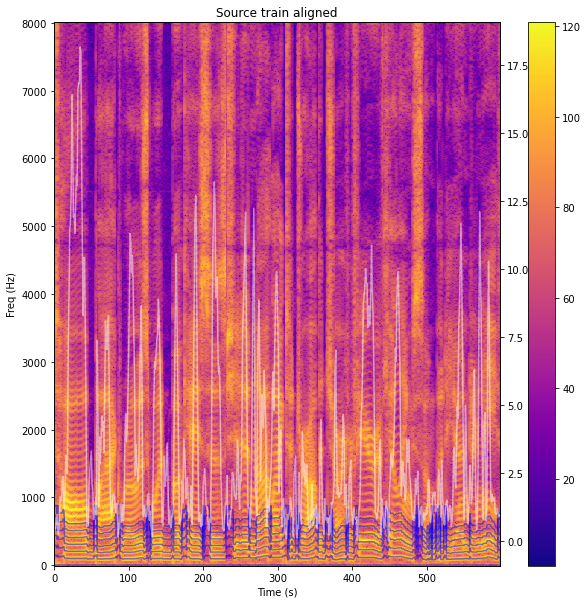

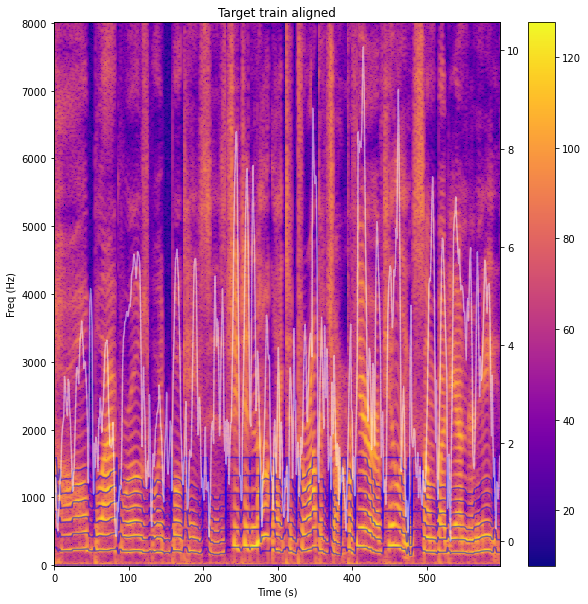

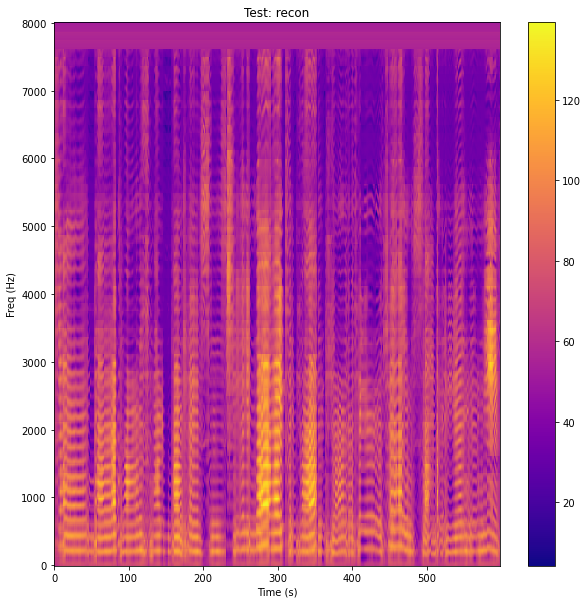

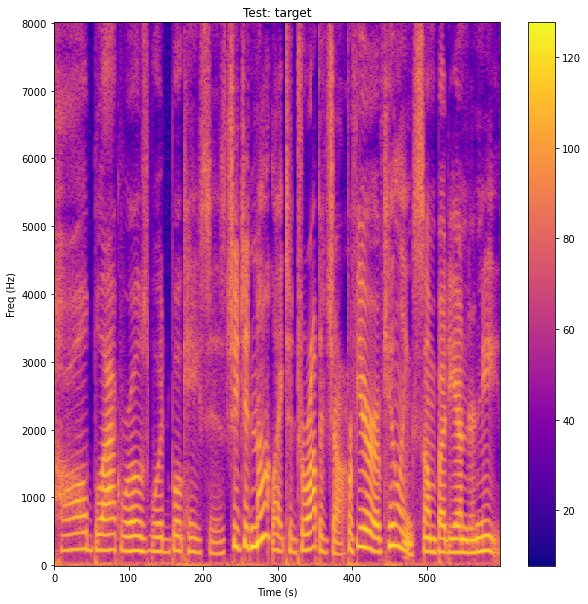

In [57]:
# test on unseen audio
test_audio_id = 5
formant_transformer_learnable_test(
    env_transformer,
    meta_data.get(3, test_audio_id), meta_data.get(0, test_audio_id),
    train=False)